In [22]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from statsmodels.stats import diagnostic
from scipy import stats
from scipy.stats import ttest_ind

# Load Data

In [2]:
data_path = './data/'
data_character = pd.read_csv(data_path + 'clean_data_character.csv')
data_original = pd.read_csv(data_path + 'clean_data_original.csv')
ethnicity_df = pd.read_csv(data_path + 'ethnicity_labels.csv')
data_success = pd.read_csv(data_path + 'clean_data_success.csv')

In [3]:
# TITLE AND ABSTRACT 

# Representation of Male and Female Actors

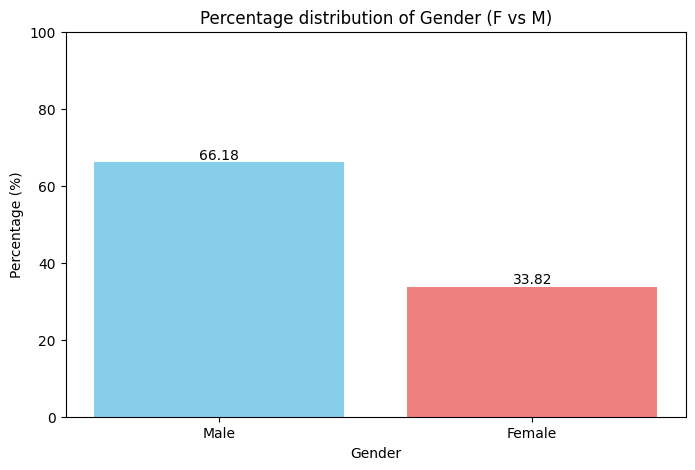

In [4]:
data_character_female = data_character[data_character["actor_gender"] == "F"]
data_character_male = data_character[data_character["actor_gender"] == "M"]
nbre_female = len(data_character_female)
nbre_male = len(data_character_male)
nbre_actors = nbre_male + nbre_female

gender_distrib= {
    'Gender': ['Male', 'Female'],
    'Percentage': [nbre_male*100/nbre_actors , nbre_female*100/nbre_actors]
}
df_gender_distrib = pd.DataFrame(gender_distrib)

plt.figure(figsize=(8, 5))
bars = plt.bar(df_gender_distrib ['Gender'], df_gender_distrib ['Percentage'], color=['skyblue', 'lightcoral'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                            
        f'{height:.2f}',                   
        ha='center',                       
        va='bottom'                         
    )

plt.title('Percentage distribution of Gender (F vs M)')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

As expected, a significant difference is observed in the number of actors between men and women. Here, men represent 66.18% of the actors, while women account for 33.82%.  
Now, the question is: even if women have always been underrepresented in cinema since its inception, has their representation increased over the years?

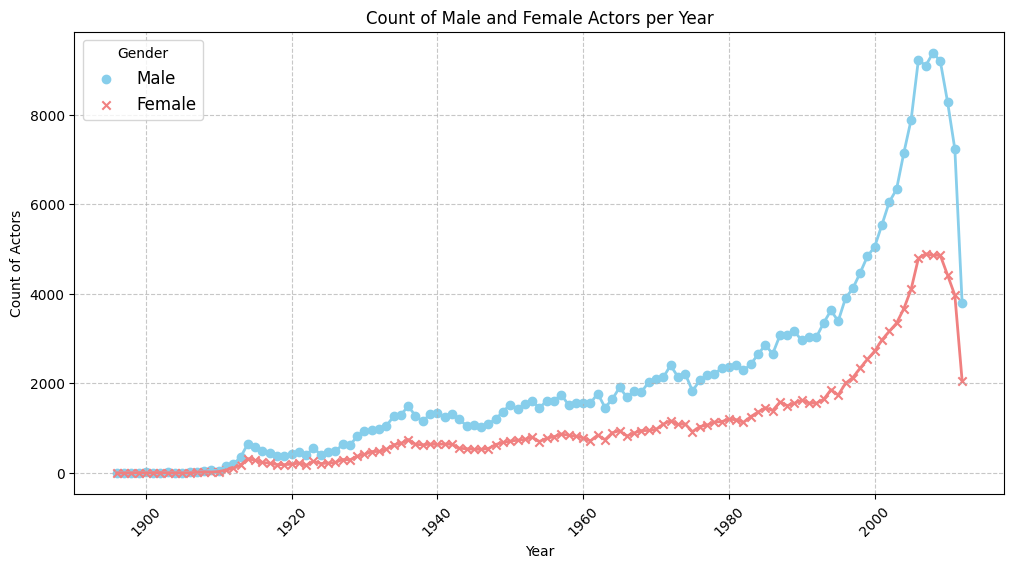

In [5]:
# Grouping data by release year and actor gender
gender_count_per_year = data_character.groupby(['release_year', 'actor_gender']).size().unstack(fill_value=0)

male_counts = gender_count_per_year['M']
female_counts = gender_count_per_year['F']
years = gender_count_per_year.index

plt.figure(figsize=(12, 6))

plt.plot(years, male_counts, color='skyblue', markersize=8, linestyle='-', linewidth=2)
plt.plot(years, female_counts, color='lightcoral', markersize=8, linestyle='-', linewidth=2)

plt.scatter(years, male_counts, color='skyblue', label='Male', marker='o')
plt.scatter(years, female_counts, color='lightcoral', label='Female', marker='x')

plt.title('Count of Male and Female Actors per Year')
plt.xlabel('Year')
plt.ylabel('Count of Actors')

plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='Gender', fontsize=12, loc='upper left', frameon=True)

plt.show()

After plotting the number of actors and actresses per year, it appears that their numbers have generally increased over the years for both, but a decline is observed after 2011. This is quite unusual, considering that the cinema industry itself has remained steady.


Upon investigation, we found that the decrease in the number of actors and actresses after 2011 is due to a decline in the number of movies in our dataset during that period. As a result, the number of actors naturally decreases, as shown in the plot below.

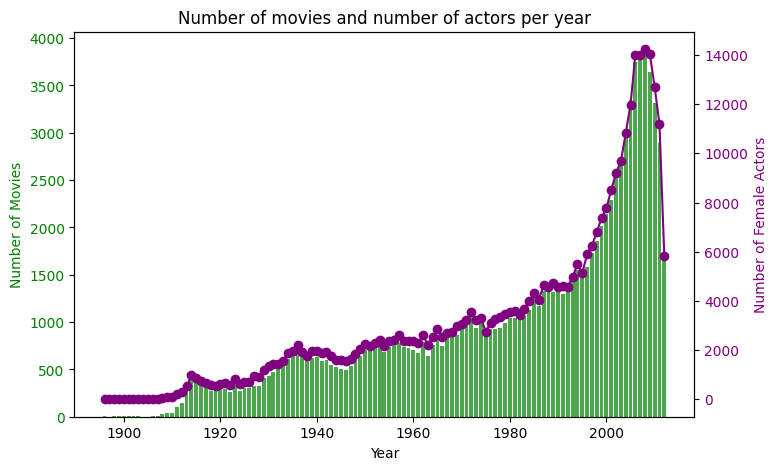

In [6]:
movies_per_year = data_character.groupby('release_year')['Wiki_ID'].nunique()

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the number of movies per year
ax1.bar(years, movies_per_year, color='green', label='Number of Movies', alpha=0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Plot female actors on a secondary axis
ax2 = ax1.twinx()
ax2.plot(years, female_counts + male_counts , color='purple', label='Number of Actors', marker='o')
ax2.set_ylabel('Number of Female Actors', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Number of movies and number of actors per year')
plt.show()

Given that the number of films per year is not consistent, to study the evolution of the number of actors over the years, it would be necessary to divide the number of actors by the number of films each year. This would make the data comparable across years.

Now, the focus is to observe whether the ratio of women to men evolves over the years.

In [7]:
# Calculate the ratio of female actors to movies per year 
ratio_male_to_movie = male_counts / movies_per_year
ratio_female_to_movie = female_counts / movies_per_year

# Calculate the ratio female/male per year 
ratio_female_male = female_counts / male_counts
ratio_female_male[male_counts == 0] = 1

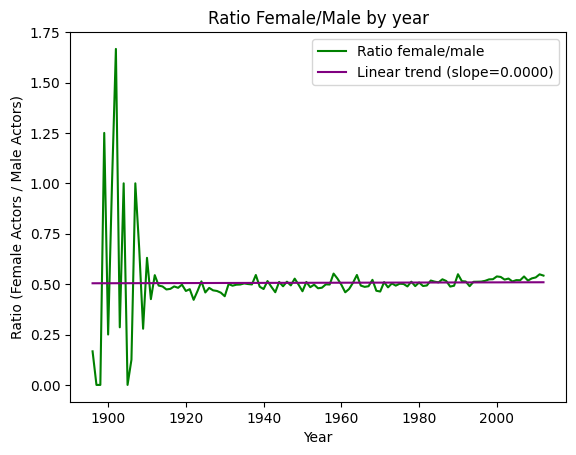

Pearson Correlation Coefficient: 0.0080, p-value: 0.9320845697302564, intercept=0.42


In [9]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(years,ratio_female_male)

sns.lineplot(x=years, y=ratio_female_male, label='Ratio female/male', color = 'green')
plt.plot(years, slope*years+intercept, color='purple',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Ratio Female/Male by year')
plt.xlabel('Year')
plt.ylabel('Ratio (Female Actors / Male Actors)')
plt.show()

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

# ICI PRENDRE PLUS QUE 500 FILMS + JUSTIFIER

Male Ratio - Pearson Correlation Coefficient: 0.8253, p-value: 2.5876780052741712e-30, intercept=-20.02
Female Ratio - Pearson Correlation Coefficient: 0.7381, p-value: 2.203536060677413e-21, intercept=-11.31


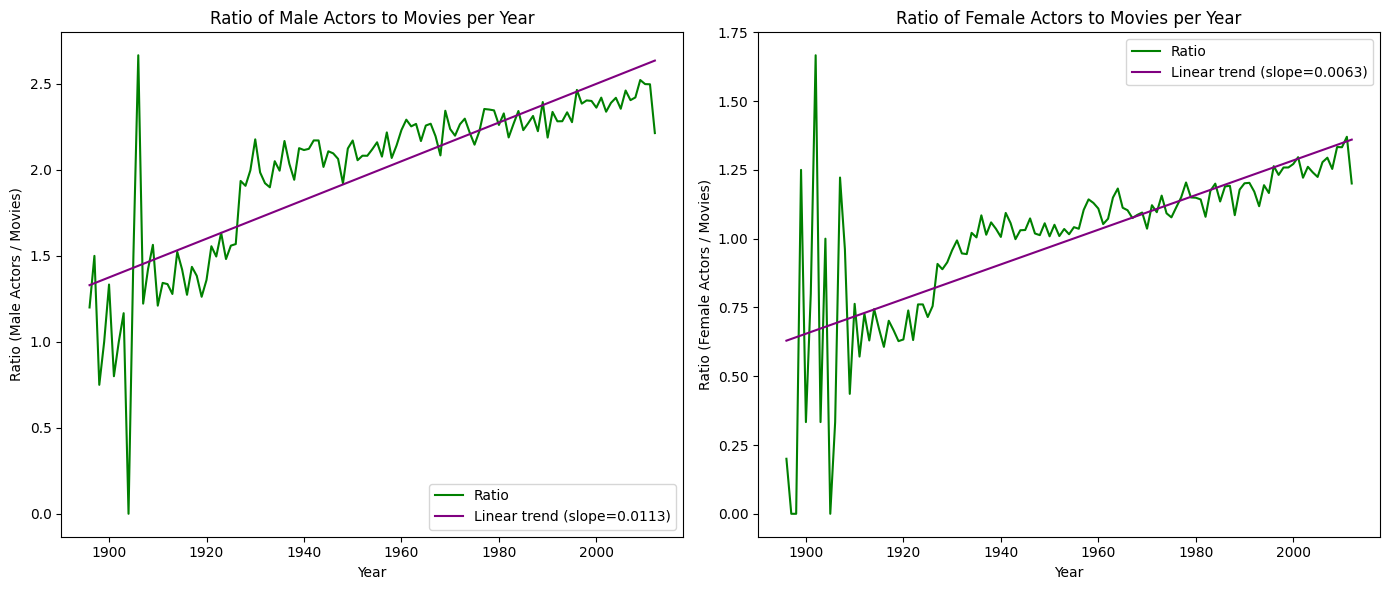

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

slope_male, intercept_male, rvalue_male, pvalue_male, stderr_male = stats.linregress(years, ratio_male_to_movie)

sns.lineplot(x=years, y=ratio_male_to_movie, label='Ratio', color= 'green', ax=axes[0])
axes[0].plot(years, slope_male * years + intercept_male, color='purple', label=f'Linear trend (slope={slope_male:.4f})')
axes[0].legend()

axes[0].set_title('Ratio of Male Actors to Movies per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Ratio (Male Actors / Movies)')

# Print statistics for Male to movie ratio
print(f"Male Ratio - Pearson Correlation Coefficient: {rvalue_male:.4f}, p-value: {pvalue_male}, intercept={intercept_male:.2f}")

# Female to movie ratio
slope_female, intercept_female, rvalue_female, pvalue_female, stderr_female = stats.linregress(years, ratio_female_to_movie)

sns.lineplot(x=years, y=ratio_female_to_movie, label='Ratio',color = 'green', ax=axes[1])
axes[1].plot(years, slope_female * years + intercept_female, color='purple', label=f'Linear trend (slope={slope_female:.4f})')
axes[1].legend()

axes[1].set_title('Ratio of Female Actors to Movies per Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Ratio (Female Actors / Movies)')

# Print statistics for Female to movie ratio
print(f"Female Ratio - Pearson Correlation Coefficient: {rvalue_female:.4f}, p-value: {pvalue_female}, intercept={intercept_female:.2f}")

plt.tight_layout()
plt.show()

Analysis of the female-to-male ratio in movies over the years reveals that, while the ratio of women to men has remained largely unchanged over the decades, the absolute number of women in films has steadily increased. The linear regression of the ratio over time shows a slope of 0, indicating that the relative representation of women in films has not significantly shifted. However, a closer examination of the raw data reveals a consistent increase in the number of women appearing in movies each year. This suggests that while women's representation in relation to men remains stable, the overall participation of women in the film industry has grown over time.

## Creation of the success metrics 

# AJOUTER LA FORMULE

To determine success metrics for the analysis, IMDb ratings (`Rating`) and box office revenue (`BoxOfficeRevenue`) are utilized. These metrics provide complementary perspectives: IMDb ratings reflect audience and critical reception, offering qualitative insights, while box office revenue quantifies financial performance, delivering measurable data. Together, they form a comprehensive framework for evaluating a movie's overall success and impact.

However, box office revenue only accounts for total earnings and does not consider the production budget, which can lead to biased evaluations. For example, a low-budget film generating three times its cost could be highly profitable but appear less successful in absolute revenue terms compared to a high-budget blockbuster.

To address this, **net box office revenue** ('Net_revenue') is introduced, defined as:  
**Net Box Office Revenue = Box Office Revenue - Initial Budget.**

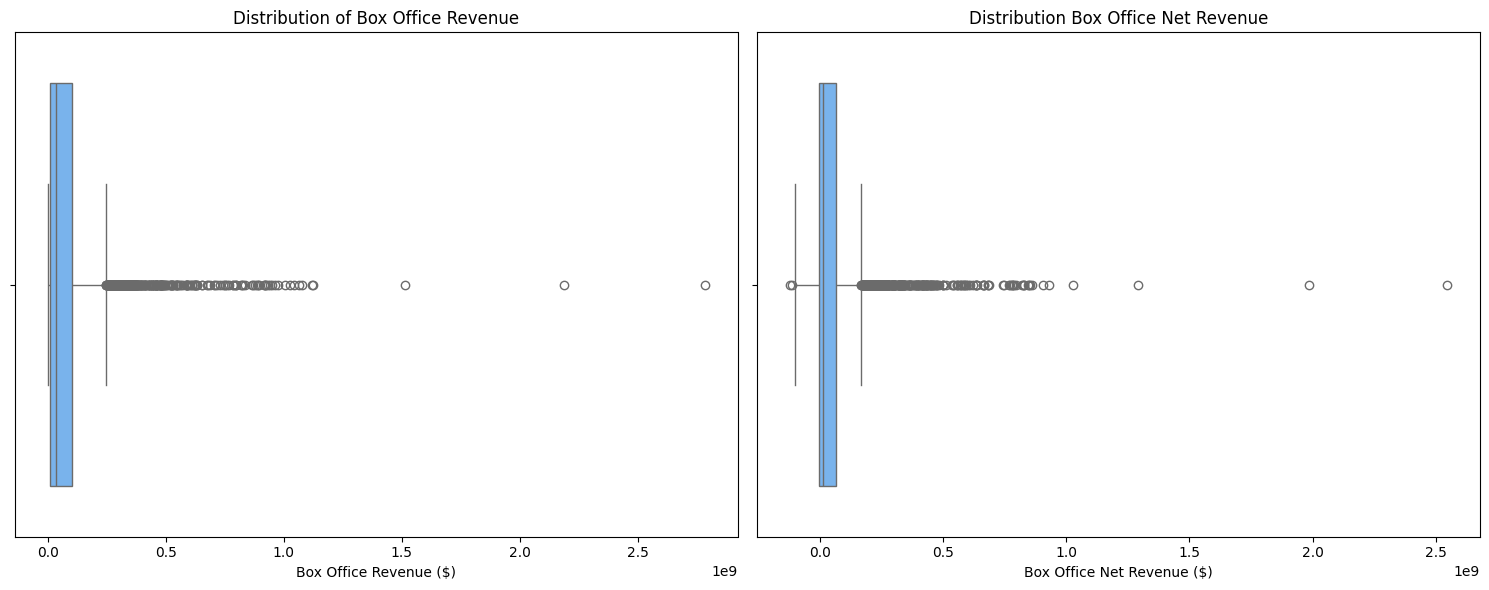

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First subplot for Box Office Revenue
sns.boxplot(data=data_success, x='BoxOfficeRevenue', color='#66b3ff', ax=axes[0])
axes[0].set_title("Distribution of Box Office Revenue")
axes[0].set_xlabel("Box Office Revenue ($)")

# Second subplot for Net Box Office Revenue
sns.boxplot(data=data_success, x='Net_revenue', color='#66b3ff', ax=axes[1])
axes[1].set_title("Distribution Box Office Net Revenue")
axes[1].set_xlabel("Box Office Net Revenue ($)")

plt.tight_layout()
plt.show()

This adjustment provides a more balanced distribution of financial performance within the metrics, offering a clearer representation of profitability and a fairer comparison across films.

To analyze the success metrics, both IMDb ratings (`Rating`) and net box office revenue were plotted to visually inspect their distributions. This allows for the assessment of whether these metrics require standardization, as the scale and range of the data could impact subsequent analyses. 

By plotting the metrics, a different distribution and scale were observed, indicating that standardization will be required when computing the success metrics.

Using rank normalization to combine box-office net revenue and IMDb ratings ensures a fair and balanced comparison between these two metrics, despite their differences in scale and distribution. By converting raw values into ranks, this approach eliminates the influence of large numerical disparities and focuses on the relative performance within each dataset. This is particularly important when integrating metrics like revenue, which is skewed by a few blockbusters, and ratings, which tend to be more evenly distributed. The result is a unified metric that captures both financial success and audience approval without bias, enabling a comprehensive and equitable evaluation.

In [9]:
data_success['BoxOfficeRank'] = data_success['Net_revenue'].rank(pct=True)
data_success['RatingRank'] = data_success['rating'].rank(pct=True)

To determine the appropriate weight for each metric when combining them, we can plot one against the other (e.g., box-office revenue vs. IMDb rating) to assess their correlation. If the correlation is weak or non-existent, it indicates that the two metrics measure different and independent aspects of success. In such a case, it would be reasonable to assign equal weights (50/50) to each metric, ensuring that neither dominates the combined metric. This approach ensures a balanced representation of both financial performance and audience approval in the final evaluation.

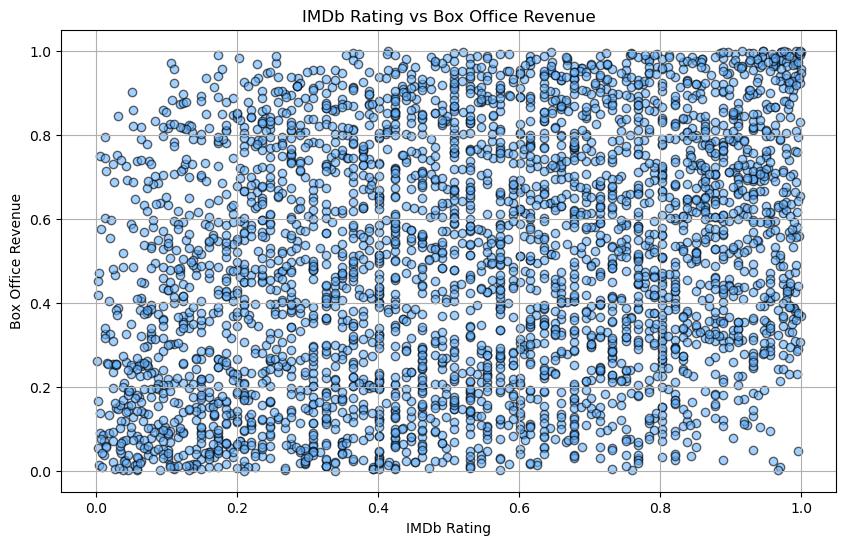

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(data_success['RatingRank'],data_success['BoxOfficeRank'],  alpha=0.6, color='#66b3ff', edgecolor='black')
plt.title("IMDb Rating vs Box Office Revenue")
plt.ylabel("Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.grid(True)
plt.show()

In [10]:
correlation = data_success['BoxOfficeRank'].corr(data_success['RatingRank'])
correlation2 = data_success['RatingRank'].corr(data_success['BoxOfficeRank'])

print(f"Correlation between Box Office and IMDb Rating: {correlation}")

Correlation between Box Office and IMDb Rating: 0.27268199436548246


No significant correlation, we can assign equal weight to both metrics.

In [14]:
weight_box_office = 0.5
weight_imdb = 0.5
data_success['SuccessMetric'] = (weight_box_office * data_success['BoxOfficeRank']) + (weight_imdb * data_success['RatingRank'])

Correlation between ratio female/male and successmetrics 

In [60]:
data_success['num_actors'] = data_success['Movie_ID'].map(
                                                    data_character.groupby('Movie_ID')['Actor_ID'].nunique()
                                                    )

data_success['num_women'] = data_success['Movie_ID'].map(
                                                    data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique()
                                                )

data_success = data_success.dropna(subset=['num_actors', 'num_women', 'SuccessMetric'])

data_success['ratio_W/M'] = np.where(data_success['num_actors'] == 0, 1, data_success['num_women'] / data_success['num_actors'])

#correlation3 = data_success['SuccessMetric'].corr(data_success['ratio_W/M'])
# Drop rows with NaN values in relevant columns

# Compute correlation between SuccessMetric and the ratio of women to men
correlation3 = data_success['SuccessMetric'].corr(data_success['ratio_W/M'])


In [61]:
correlation3

-0.06281659095098419

In [55]:
correlation3

-0.06281659095098419

In [ ]:
data_corr_genre = datasuccess.copy()



analysis = pd.merge(
                        women_data[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
                        data_imdb_women.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'ratio_W/M', 'Rating']],
                        on='Movie_ID',
                        how = 'inner'
                        )

mean_women_data = analysis.groupby('Movie_ID').agg(
                                                    mean_age=('actor_age_movie_released', 'mean'),
                                                    num_women=('actor_age_movie_released', 'size'),
                                                    title=('title', 'first'),
                                                    SuccessMetric=('SuccessMetric', 'first'),
                                                    ratio_W_M = ('ratio_W/M', 'first'),
                                                    ethnicities = ('ethnic_cat', lambda x: [eth for eth in x if pd.notna(eth)]),
                                                    avg_height = ('actor_height', 'mean'),
                                                    Rating = ('Rating', 'first')
                                                ).reset_index()

# Ethnicity correlation

Create a numerical categorical variable associated with the different ethnicities

In [12]:
ethnicity_df['ethnic_cat'] = ethnicity_df.index
data_character = pd.merge(data_character, ethnicity_df[['ethnicity_ID', 'ethnic_cat']], on='ethnicity_ID', how='left')

Add a line with the ratio of Women within the main actors in the films

In [13]:
data_success['num_actors'] = data_success['Movie_ID'].map(data_character.groupby('Movie_ID')['Actor_ID'].nunique())
data_success['num_women'] = data_success['Movie_ID'].map(data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique())
data_success['ratio_W/M'] = data_success['num_women']/data_success['num_actors']

In [14]:
women_data = data_character[data_character['actor_gender']=='F'].copy()
men_data = data_character[data_character['actor_gender']=='M'].copy()

We will only consider the ethnicities for which we have a minimum of 30 different actors. Else, it doesn't seem to be enough to draw any conclusions.

In [15]:
low_count_ethnicities = ethnicity_df.loc[ethnicity_df['count'] < 30, 'ethnic_cat'].tolist()
women_data_ethnicity = women_data.copy()
women_data_ethnicity['ethnic_cat'] = women_data['ethnic_cat'].apply(lambda x: pd.NA if x in low_count_ethnicities else x)

We will keep only movies with at least 4 actors and 10% actress since we are focusing on actress.

In [16]:
valid_mask = (data_success['ratio_W/M'] >= 0.1) & (data_success['num_actors'] > 4)
movies_women = data_success[valid_mask].copy()

In [17]:
analysis = pd.merge(
                        women_data_ethnicity[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
                        movies_women.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'ratio_W/M', 'rating']],
                        on='Movie_ID',
                        how = 'inner'
                        )

mean_women_data = analysis.groupby('Movie_ID').agg(
                                                    mean_age=('actor_age_movie_released', 'median'),
                                                    num_women=('actor_age_movie_released', 'size'),
                                                    title=('title', 'first'),
                                                    SuccessMetric=('SuccessMetric', 'first'),
                                                    ratio_W_M = ('ratio_W/M', 'first'),
                                                    ethnicities = ('ethnic_cat', lambda x: [eth for eth in x if pd.notna(eth)]),
                                                    avg_height = ('actor_height', 'mean'),
                                                    Rating = ('rating', 'first')
                                                ).reset_index()
print(f"The total number of movies with a success metrics is {mean_women_data.shape[0]}.")

The total number of movies with a success metrics is 3277.


We will remove movies with less than 30 different movies.

In [19]:
ethnicity_counts = pd.Series([eth for sublist in mean_women_data['ethnicities'] for eth in sublist if pd.notna(eth)]).value_counts()
valid_ethnicities = ethnicity_counts[ethnicity_counts >= 30].index

mean_women_data['ethnicities'] = mean_women_data['ethnicities'].apply(
    lambda eth_list: [eth for eth in eth_list if eth in valid_ethnicities]
)

mean_women_data_ethnicity = mean_women_data[mean_women_data['ethnicities'].apply(len) > 0]

print(f"The total number of movies with a success metrics and enough ethnicities is {mean_women_data_ethnicity.shape[0]}.")


The total number of movies with a success metrics and enough ethnicities is 2149.


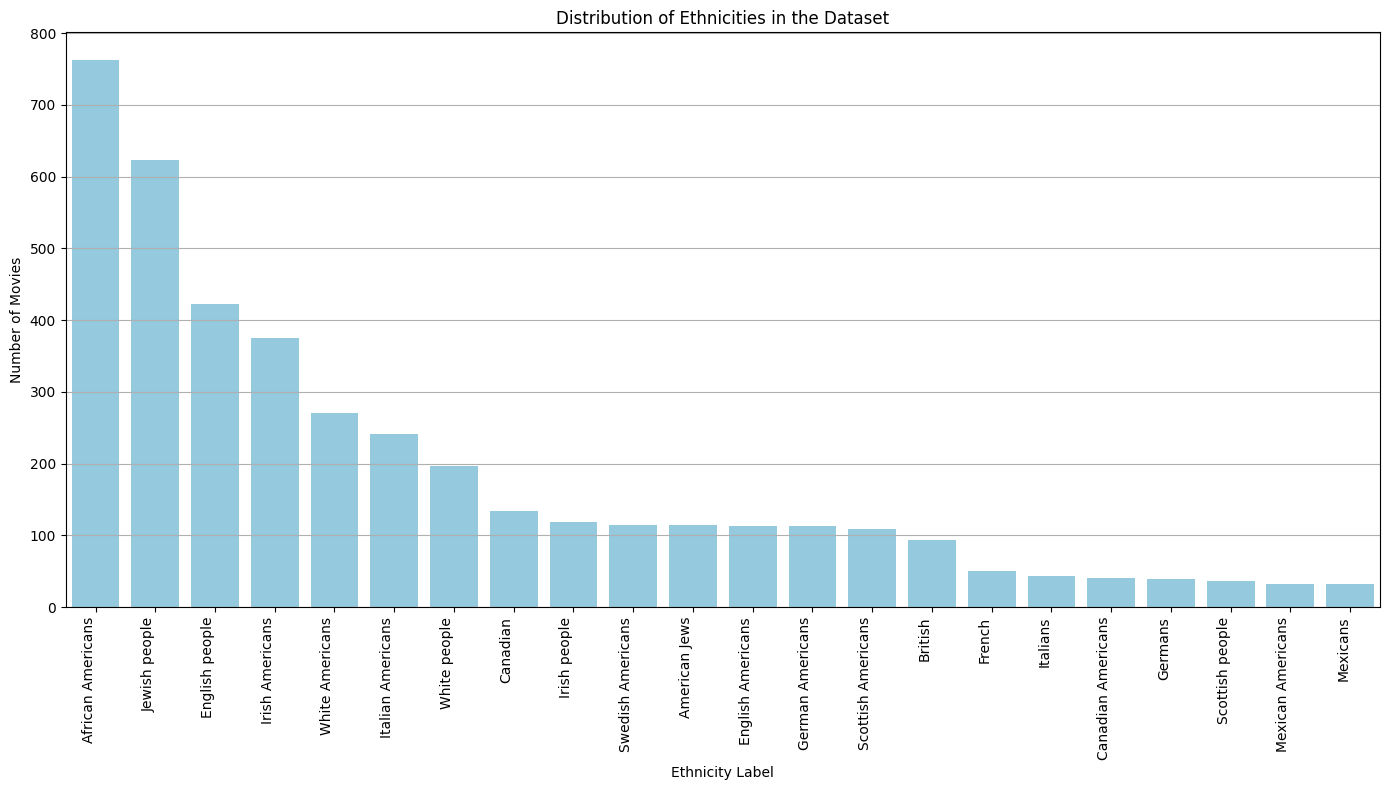

In [20]:
ethnicity_counts = pd.Series([eth for sublist in mean_women_data_ethnicity['ethnicities'] for eth in sublist if pd.notna(eth)])
ethnicity_distribution = ethnicity_counts.value_counts().reset_index()
ethnicity_distribution.columns = ['ethnic_cat', 'count']

ethnicity_distribution = pd.merge(
    ethnicity_distribution,
    ethnicity_df[['ethnic_cat', 'ethnicity_label']],
    on='ethnic_cat',
    how='left'
)

ethnicity_distribution = ethnicity_distribution.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x='ethnicity_label', y='count', data=ethnicity_distribution, color='skyblue')
plt.title("Distribution of Ethnicities in the Dataset")
plt.xlabel("Ethnicity Label")
plt.ylabel("Number of Movies")
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The distribution of the data on the different ethnicities is not equally distributed at all. We will have to be carefull with this.

# Establish relationship between ethnicities and SuccessMetric

We looked at the difference of mean success metrics between movies containing at least one actress from an ethnicity compared to all other movies. Then we performed a t-test using equal_var=False to compensate the fact that the distribution is not even for every ethnicity.

In [23]:
results_list = []

# Get the list of unique ethnic categories
all_ethnic_cats = pd.Series([eth for sublist in mean_women_data_ethnicity['ethnicities'] for eth in sublist if pd.notna(eth)]).unique()


for ethnic_cat in all_ethnic_cats:
    # Filter out movies that include this ethnic category
    movies_with_ethnic_cat = mean_women_data_ethnicity[mean_women_data_ethnicity['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat in x)]
    movies_without_ethnic_cat = mean_women_data_ethnicity[mean_women_data_ethnicity['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat not in x)]

    if len(movies_with_ethnic_cat) < 2 or len(movies_without_ethnic_cat) < 2:
        print(f"Not enough movies for comparison for ethnicity: {ethnic_cat}")
        continue
    
    # Calculate mean success scores on each group
    mean_with = movies_with_ethnic_cat['SuccessMetric'].mean()
    mean_without = movies_without_ethnic_cat['SuccessMetric'].mean()
    
    # Check for low variance or insufficient unique values
    if movies_with_ethnic_cat['SuccessMetric'].nunique() < 2 or movies_without_ethnic_cat['SuccessMetric'].nunique() < 2:
        t_stat, p_value = np.nan, np.nan
    else:
        t_stat, p_value = ttest_ind(
            movies_with_ethnic_cat['SuccessMetric'].dropna(),
            movies_without_ethnic_cat['SuccessMetric'].dropna(),
            equal_var=False
        )
    
    results_list.append({
        'ethnic_cat': ethnic_cat,
        'nb_movies_with':  len(movies_with_ethnic_cat),
        'nb_movies_without': len(movies_without_ethnic_cat),
        'mean_diff': mean_with - mean_without,
        'mean_with_ethnic_cat': mean_with,
        'mean_without_ethnic_cat': mean_without,
        't_stat': t_stat,
        'p_value': p_value
    })


results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='p_value')


In [24]:
results_df.head(8)

,ethnic_cat,nb_movies_with,nb_movies_without,mean_diff,mean_with_ethnic_cat,mean_without_ethnic_cat,t_stat,p_value
1,24.0,314,1835,0.062532,0.569987,0.507455,4.377817,0.000015
8,113.0,35,2114,0.154195,0.668275,0.514081,4.369022,0.000104
7,7.0,111,2038,-0.052965,0.466363,0.519328,-2.158326,0.032895
4,75.0,86,2063,0.055050,0.569439,0.514389,2.123703,0.036383
5,3.0,543,1606,-0.019150,0.502281,0.521431,-1.716443,0.086399
2,48.0,245,1904,0.025585,0.539260,0.513675,1.695429,0.090978
6,25.0,115,2034,0.037193,0.551795,0.514602,1.657725,0.099847
10,0.0,125,2024,-0.033394,0.485141,0.518534,-1.654177,0.100306


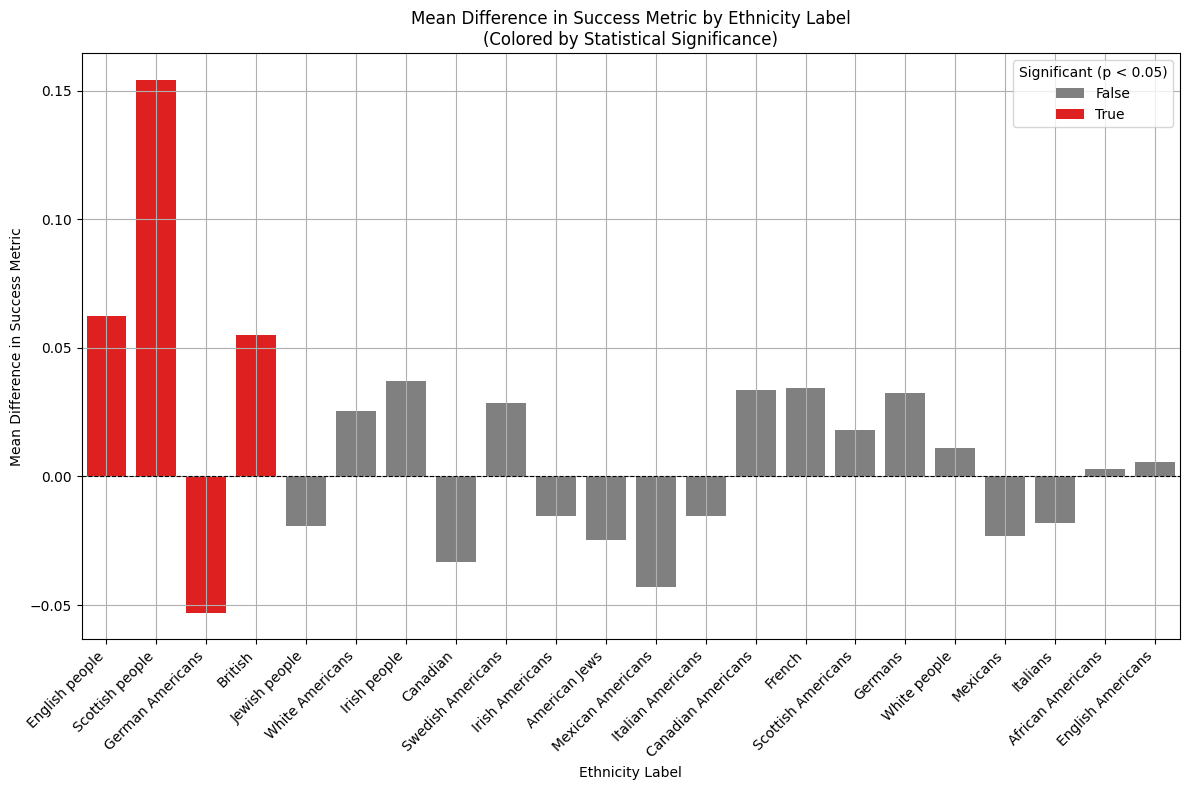

In [25]:

merged_df = pd.merge(results_df, ethnicity_df[['ethnic_cat', 'ethnicity_label']], on='ethnic_cat', how='left')
merged_df_clean = merged_df.dropna(subset=['p_value'])
merged_df_clean['Significant'] = merged_df_clean['p_value'] < 0.05

plt.figure(figsize=(12, 8))
sns.barplot(
    data=merged_df_clean,
    x='ethnicity_label', y='mean_diff',
    hue='Significant',
    palette={True: 'red', False: 'gray'}
)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Ethnicity Label")
plt.ylabel("Mean Difference in Success Metric")
plt.title("Mean Difference in Success Metric by Ethnicity Label\n(Colored by Statistical Significance)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Significant (p < 0.05)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Investigating correlation between Actress' Height, Age and Movie's success metrics

First, let's try to see if there seem to be any link between the actress's age and the Movie Success Score with only looking at the scatter plot.

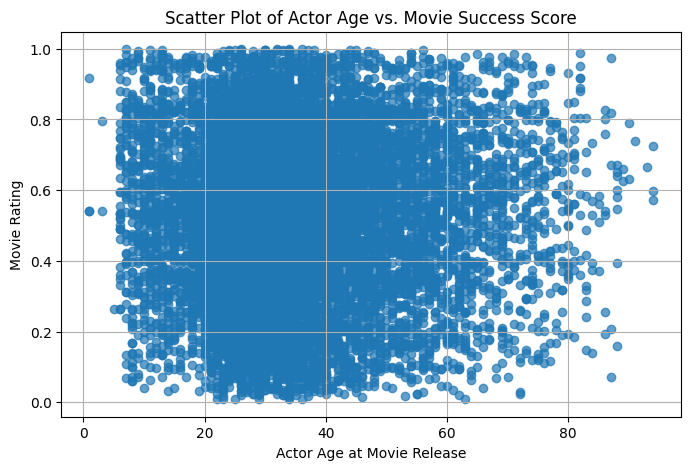

In [26]:
import matplotlib.pyplot as plt

# Example data
x = analysis['actor_age_movie_released']
y = analysis['SuccessMetric']

# Basic scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Actor Age at Movie Release")
plt.ylabel("Movie Rating")
plt.title("Scatter Plot of Actor Age vs. Movie Success Score")
plt.grid(True)
plt.show()

In [27]:
ages = mean_women_data['mean_age']
success_scores = mean_women_data['Rating']

valid_mask = ~np.isnan(ages) & ~np.isnan(success_scores)

correlation = np.corrcoef(ages[valid_mask], success_scores[valid_mask])[0, 1]

print(f"Correlation between actress age and movie success score: {correlation}")

Correlation between actress age and movie success score: 0.061325548999003096


There is no evident link between the two variables. The correlation is very low, the two variables are not correlated.

Let's look now at the link between the actress's mean age and the Movie Success Score

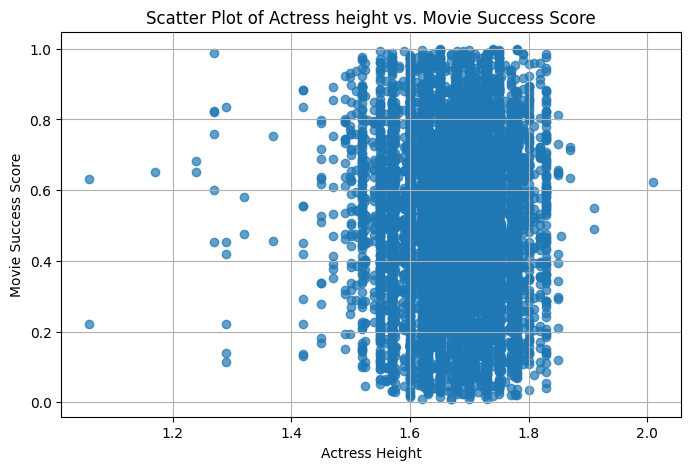

In [28]:
x = analysis['actor_height']
y = analysis['SuccessMetric']

plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Actress Height")
plt.ylabel("Movie Success Score")
plt.title("Scatter Plot of Actress height vs. Movie Success Score")
plt.grid(True)
plt.show()

In [29]:
ages = mean_women_data['avg_height']
success_scores = mean_women_data['Rating']

valid_mask = ~np.isnan(ages) & ~np.isnan(success_scores)

correlation = np.corrcoef(ages[valid_mask], success_scores[valid_mask])[0, 1]

print(f"Correlation between actress height and movie success score: {correlation}")

Correlation between actress height and movie success score: -0.0393468589568836


There is no evident link between the two variables. The correlation is very low, the two variables are not correlated.

We will now make sure that the two variables are not crosscorrelated.

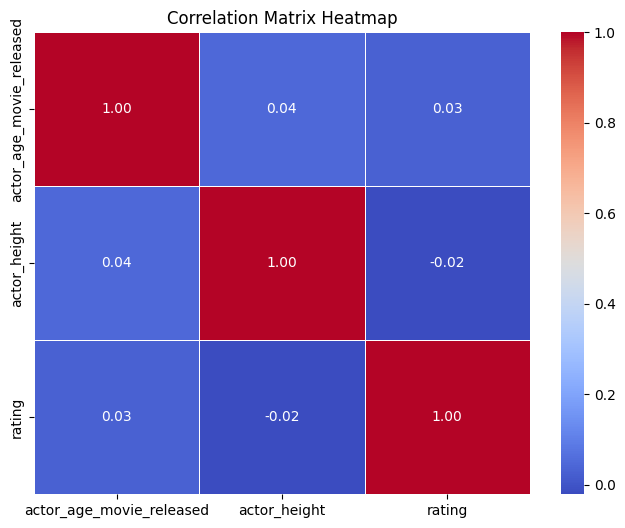

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = analysis[['actor_age_movie_released', 'actor_height', 'rating']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


There is no evident link between the actresses height and age and the success of the movie. We will therefore not be able to include the age and height in the model we first intended to do.